# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=45,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_14-39-31/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5141 | MulticlassF1Score=0.1633
Batch-30 : CrossEntropyLoss=2.4499 | MulticlassF1Score=0.2087
Batch-45 : CrossEntropyLoss=2.4472 | MulticlassF1Score=0.2382
Batch-60 : CrossEntropyLoss=2.4267 | MulticlassF1Score=0.2907
Batch-75 : CrossEntropyLoss=2.3962 | MulticlassF1Score=0.3331
Batch-90 : CrossEntropyLoss=2.4022 | MulticlassF1Score=0.3641
Batch-105: CrossEntropyLoss=2.3809 | MulticlassF1Score=0.3894
Batch-120: CrossEntropyLoss=2.3570 | MulticlassF1Score=0.4137
Batch-135: CrossEntropyLoss=2.3755 | MulticlassF1Score=0.4336
Batch-150: CrossEntropyLoss=2.3640 | MulticlassF1Score=0.4487
Batch-165: CrossEntropyLoss=2.3757 | MulticlassF1Score=0.4621
Batch-180: CrossEntropyLoss=2.3801 | MulticlassF1Score=0.4724
Batch-195: CrossEntropyLoss=2.3710 | MulticlassF1Score=0.4819
Batch-210: CrossEntropyLoss=2.3779 | MulticlassF1Score=0.4904
Batch-225: CrossEntropyLoss=2.3804 | MulticlassF1Score=0.4975
Batch-226: CrossEntropyLoss=2.3672 | MulticlassF1Score=0.4978

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3933 | MulticlassF1Score=0.5968
Batch-30 : CrossEntropyLoss=2.3732 | MulticlassF1Score=0.5959
Batch-45 : CrossEntropyLoss=2.3606 | MulticlassF1Score=0.5965
Batch-60 : CrossEntropyLoss=2.3760 | MulticlassF1Score=0.5950
Batch-63 : CrossEntropyLoss=2.3744 | MulticlassF1Score=0.5952

Training   : Mean CrossEntropyLoss = 2.4138 | Mean MulticlassF1Score = 0.3681
Validation : Mean CrossEntropyLoss = 2.3735 | Mean MulticlassF1Score = 0.5972

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3757 | MulticlassF1Score=0.5924
Batch-30 : CrossEntropyLoss=2.3647 | MulticlassF1Score=0.5912
Batch-45 : CrossEntropyLoss=2.3640 | MulticlassF1Score=0.5928
Batch-60 : CrossEntropyLoss=2.3711 | MulticlassF1Score=0.5933
Batch-75 : CrossEntropyLoss=2.3685 | MulticlassF1Score=0.5937
Batch-90 : CrossEntropyLoss=2.3903 | MulticlassF1Score=0.5957
Batch-105: CrossEntropyLoss=2.3616 | MulticlassF1Score=0.5966
Batch-120: CrossEntropyLoss=2.3646 | MulticlassF1Score=0.5977
Batch-135: CrossEntropyLoss=2.3443 | MulticlassF1Score=0.6045
Batch-150: CrossEntropyLoss=2.3367 | MulticlassF1Score=0.6125
Batch-165: CrossEntropyLoss=2.3711 | MulticlassF1Score=0.6188
Batch-180: CrossEntropyLoss=2.3447 | MulticlassF1Score=0.6231
Batch-195: CrossEntropyLoss=2.3532 | MulticlassF1Score=0.6269
Batch-210: CrossEntropyLoss=2.3348 | MulticlassF1Score=0.6313
Batch-225: CrossEntropyLoss=2.3494 | MulticlassF1Score=0.6355
Batch-226: CrossEntropyLoss=2.3376 | MulticlassF1Score=0.6358

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3303 | MulticlassF1Score=0.6881
Batch-30 : CrossEntropyLoss=2.3510 | MulticlassF1Score=0.6873
Batch-45 : CrossEntropyLoss=2.3538 | MulticlassF1Score=0.6880
Batch-60 : CrossEntropyLoss=2.3534 | MulticlassF1Score=0.6901
Batch-63 : CrossEntropyLoss=2.3480 | MulticlassF1Score=0.6895

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3609 | Mean MulticlassF1Score = 0.6063
Validation : Mean CrossEntropyLoss = 2.3445 | Mean MulticlassF1Score = 0.6881

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3340 | MulticlassF1Score=0.6917
Batch-30 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7108
Batch-45 : CrossEntropyLoss=2.3280 | MulticlassF1Score=0.7173
Batch-60 : CrossEntropyLoss=2.3226 | MulticlassF1Score=0.7219
Batch-75 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7315
Batch-90 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.7410
Batch-105: CrossEntropyLoss=2.3160 | MulticlassF1Score=0.7495
Batch-120: CrossEntropyLoss=2.3241 | MulticlassF1Score=0.7553
Batch-135: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7598
Batch-150: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.7644
Batch-165: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7684
Batch-180: CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7713
Batch-195: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7739
Batch-210: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7762
Batch-225: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7779
Batch-226: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.7780

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7984
Batch-30 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8035
Batch-45 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8064
Batch-60 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8029
Batch-63 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8033

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3174 | Mean MulticlassF1Score = 0.7444
Validation : Mean CrossEntropyLoss = 2.3092 | Mean MulticlassF1Score = 0.8044

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8130
Batch-30 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8102
Batch-45 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8099
Batch-60 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8103
Batch-75 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8082
Batch-90 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8069
Batch-105: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8071
Batch-120: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8066
Batch-135: CrossEntropyLoss=2.3206 | MulticlassF1Score=0.8064
Batch-150: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8065
Batch-165: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8070
Batch-180: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8073
Batch-195: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8073
Batch-210: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8078
Batch-225: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8079
Batch-226: CrossEntropyLoss=2.3132 | MulticlassF1Score=0.8078

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8059
Batch-30 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8079
Batch-45 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8065
Batch-60 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8056
Batch-63 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8053

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3074 | Mean MulticlassF1Score = 0.8085
Validation : Mean CrossEntropyLoss = 2.3082 | Mean MulticlassF1Score = 0.8056

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8218
Batch-30 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8153
Batch-45 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8129
Batch-60 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8131
Batch-75 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8128
Batch-90 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8123
Batch-105: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8110
Batch-120: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8103
Batch-135: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8103
Batch-150: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8101
Batch-165: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8100
Batch-180: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8106
Batch-195: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8123
Batch-210: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8141
Batch-225: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8147
Batch-226: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8148

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8283
Batch-30 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8265
Batch-45 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8255
Batch-60 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8264
Batch-63 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3050 | Mean MulticlassF1Score = 0.8132
Validation : Mean CrossEntropyLoss = 2.3016 | Mean MulticlassF1Score = 0.8255

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8312
Batch-30 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8318
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8315
Batch-60 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8321
Batch-75 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8321
Batch-90 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8321
Batch-105: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8322
Batch-120: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8312
Batch-135: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8311
Batch-150: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8313
Batch-165: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8317
Batch-180: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8319
Batch-195: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8317
Batch-210: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8317
Batch-225: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8321
Batch-226: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8322

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8335
Batch-30 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8299
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8292
Batch-60 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8286
Batch-63 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8321
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8309

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8368
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8373
Batch-45 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8366
Batch-60 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8366
Batch-75 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8355
Batch-90 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8351
Batch-105: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8338
Batch-120: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8327
Batch-135: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8330
Batch-150: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8338
Batch-165: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8340
Batch-180: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8341
Batch-195: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8335
Batch-210: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8337
Batch-225: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8339
Batch-226: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8339

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8284
Batch-30 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8269
Batch-45 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8287
Batch-60 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8276
Batch-63 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2990 | Mean MulticlassF1Score = 0.8348
Validation : Mean CrossEntropyLoss = 2.3010 | Mean MulticlassF1Score = 0.8284

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8380
Batch-30 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8419
Batch-45 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8388
Batch-60 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8355
Batch-75 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8340
Batch-90 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8345
Batch-105: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8352
Batch-120: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8352
Batch-135: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8351
Batch-150: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8347
Batch-165: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8344
Batch-180: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8344
Batch-195: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8348
Batch-210: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8348
Batch-225: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8355
Batch-226: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8356

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8307
Batch-30 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8347
Batch-45 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8356
Batch-60 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8364
Batch-63 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8365

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8361
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8347

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8457
Batch-30 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8442
Batch-45 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8447
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8472
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8468
Batch-90 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8473
Batch-105: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8471
Batch-120: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8459
Batch-135: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8452
Batch-150: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8449
Batch-165: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8447
Batch-180: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8441
Batch-195: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8439
Batch-210: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8439
Batch-225: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8441
Batch-226: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8441
Batch-30 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8370
Batch-45 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8370
Batch-60 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8373
Batch-63 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8375

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2958 | Mean MulticlassF1Score = 0.8454
Validation : Mean CrossEntropyLoss = 2.2980 | Mean MulticlassF1Score = 0.8392

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8503
Batch-30 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8492
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8468
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8467
Batch-75 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8484
Batch-90 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8475
Batch-105: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8470
Batch-120: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8461
Batch-135: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8456
Batch-150: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8457
Batch-165: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8458
Batch-180: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8455
Batch-195: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8453
Batch-210: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8455
Batch-225: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8454
Batch-226: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8398
Batch-30 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8387
Batch-45 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8355
Batch-60 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8370
Batch-63 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8367

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2954 | Mean MulticlassF1Score = 0.8467
Validation : Mean CrossEntropyLoss = 2.2983 | Mean MulticlassF1Score = 0.8391

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8513
Batch-30 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8493
Batch-45 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8498
Batch-60 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8487
Batch-75 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8478
Batch-90 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8496
Batch-105: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8507
Batch-120: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8523
Batch-135: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8532
Batch-150: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8546
Batch-165: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8549
Batch-180: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8556
Batch-195: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8558
Batch-210: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8563
Batch-225: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8568
Batch-226: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8567

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8526
Batch-30 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8521
Batch-45 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8538
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8547
Batch-63 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8551

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2921 | Mean MulticlassF1Score = 0.8522
Validation : Mean CrossEntropyLoss = 2.2929 | Mean MulticlassF1Score = 0.8536

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8633
Batch-30 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8664
Batch-45 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8658
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8680
Batch-75 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8708
Batch-90 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8727
Batch-105: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8752
Batch-120: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8769
Batch-135: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8777
Batch-150: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8786
Batch-165: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8792
Batch-180: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8802
Batch-195: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8810
Batch-210: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8820
Batch-225: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8826
Batch-226: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8826

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8816
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8806
Batch-45 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8795
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8816
Batch-63 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8818

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8743
Validation : Mean CrossEntropyLoss = 2.2845 | Mean MulticlassF1Score = 0.8809

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8889
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.8924
Batch-45 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8914
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8910
Batch-75 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8911
Batch-90 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8911
Batch-105: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8918
Batch-120: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8918
Batch-135: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8924
Batch-150: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8921
Batch-165: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8918
Batch-180: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8921
Batch-195: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8922
Batch-210: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8922
Batch-225: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8921
Batch-226: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8921

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8755
Batch-30 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8791
Batch-45 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8830
Batch-60 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8832
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8832

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8917
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8796

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8959
Batch-30 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8939
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8940
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8954
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8957
Batch-90 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8955
Batch-105: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8961
Batch-120: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8955
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8952
Batch-150: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8954
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8957
Batch-180: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8958
Batch-195: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8958
Batch-210: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8958
Batch-225: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8953
Batch-226: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8953

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8838
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8872
Batch-45 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8858
Batch-60 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8855
Batch-63 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8856

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2801 | Mean MulticlassF1Score = 0.8954
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8853

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8957
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8947
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8963
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8965
Batch-75 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8964
Batch-90 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8976
Batch-105: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8986
Batch-120: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8986
Batch-135: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8992
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8994
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8997
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9000
Batch-195: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9004
Batch-210: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9003
Batch-225: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9002
Batch-226: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9002

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8895
Batch-30 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8907
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8908
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8906
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.8908

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.8981
Validation : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8904

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9048
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9025
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9039
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9040
Batch-75 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9040
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9042
Batch-105: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9042
Batch-120: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9039
Batch-135: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9036
Batch-150: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9036
Batch-165: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9031
Batch-180: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9032
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9033
Batch-210: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9031
Batch-225: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9031
Batch-226: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9031

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8887
Batch-45 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8922
Batch-63 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8920

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9038
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8894

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9050
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9037
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9049
Batch-60 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.9046
Batch-75 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9029
Batch-90 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9027
Batch-105: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9032
Batch-120: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9038
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9040
Batch-150: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9045
Batch-165: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9048
Batch-180: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9048
Batch-195: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9046
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9047
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9048
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9047

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8960
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8958
Batch-45 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8933
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8931
Batch-63 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8929

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9044
Validation : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8945

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9022
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9061
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9073
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9066
Batch-75 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9072
Batch-90 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9065
Batch-105: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9061
Batch-120: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9066
Batch-135: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9062
Batch-150: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9059
Batch-165: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9058
Batch-180: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9056
Batch-195: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9058
Batch-210: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9058
Batch-225: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9059
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9059

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8888
Batch-30 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8911
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8928
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8936
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8939

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9057
Validation : Mean CrossEntropyLoss = 2.2806 | Mean MulticlassF1Score = 0.8913

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9081
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9090
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9092
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9130
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9169
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9191
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9204
Batch-120: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9218
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9229
Batch-150: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9234
Batch-165: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9238
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9242
Batch-195: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9249
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9255
Batch-225: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9257
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9258

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9201
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9168
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9162
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9178
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9180

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9185
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9184

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9331
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9339
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9342
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9337
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9343
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9347
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9351
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9356
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9352
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9353
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9352
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9354
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9355
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9356
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9356

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9206
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9347
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9215

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9412
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9400
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9399
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9395
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9387
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9386
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9384
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9388
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9387
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9387

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9391
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9236

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9406
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9402
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9394
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9396
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9397
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9396
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9393
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9397
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9397
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9397

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9224
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9235

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9403
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9208

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9420
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9416
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9411
Batch-150: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9410
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9406
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9403
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9402
Batch-225: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9237
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9235

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9414
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9236

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9386
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9400
Batch-90 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9399
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9401
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9405
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9401
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9403
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9402
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9403
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9403
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9403

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9398
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9232

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9387
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9385
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9393
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9394
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9400
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9402
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9400
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9401
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9405
Batch-226: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9404

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9221

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9417
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9420
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9242
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9235

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9413
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9232

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9422
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9410
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9418
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9417
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9418
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9416
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9416

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9415
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9258

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9398
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9400
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9401
Batch-105: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9404
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9408
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9414
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9415
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9419
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9210

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9430
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9428
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9247

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9436
Batch-75 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9442
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9444
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9238
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9446
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9257

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9447
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9451
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9450
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9449
Batch-226: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9290
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9282

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9441
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9444
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9443
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9448
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9451
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9248

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9459
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9455
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9451
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9452
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9451
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9256

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9258
Patience = 1/50❗

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9476
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9477
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9475
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9472
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9458
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9457
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9456
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9278

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9460
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9466
Batch-210: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9268
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9265

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9460
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9266

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9481
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9469
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9473
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9254
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9229

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9469
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9474
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9472
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9471
Batch-180: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9469
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9468
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9268

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9474
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9255
Patience = 2/50❗

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9471
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9478
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9482
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9484
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9488
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9487
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9487

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9307
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9306
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9304
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9305

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9295

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9515
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9508
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9500
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9506
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9528
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9548
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9564
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9575
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9588
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9598
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9605
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9613
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9619
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9619

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2593 | Mean MulticlassF1Score = 0.9550
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9479

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9706
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9707
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9707
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9705

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9489

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9709
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9709
Batch-226: CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9515
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9703
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9493

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9707
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9707
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9470

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9741
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9712
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9716
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9714
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9712
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9509
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9501

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9696
Batch-30 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9707
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9713
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9709
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9498
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9496

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9707
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9497
Patience = 3/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9722
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9726
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9726
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9726
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9516
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9484

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9502
Patience = 4/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9707
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9706
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9705
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9491

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9495
Patience = 5/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9736
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9711
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9482

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9708
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9710
Batch-90 : CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9715
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9717
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9717
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9496

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9484

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9735
Batch-30 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9732
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9727
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9721
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9726
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9726
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9724
Batch-135: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9729
Batch-150: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9730
Batch-165: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9728
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9727
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9725
Batch-210: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9724
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9497

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9727
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9486

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9743
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9725
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9726
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9727
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9729
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9728
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9727
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9726
Batch-135: CrossEntropyLoss=2.2517 | MulticlassF1Score=0.9728
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9729
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9728
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9728
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9727
Batch-210: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9725
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9725
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9725

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9520
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9517
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9503
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9504

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2559 | Mean MulticlassF1Score = 0.9728
Validation : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9511

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2559
Best CrossEntropyLoss training    : 2.2629
Best MulticlassF1Score validation : 0.9728
Best MulticlassF1Score validation : 0.9511
Training duration                 : 2.6069 minutes.
Training date                     : 2022-10-19 10:41:50.770111+08:00


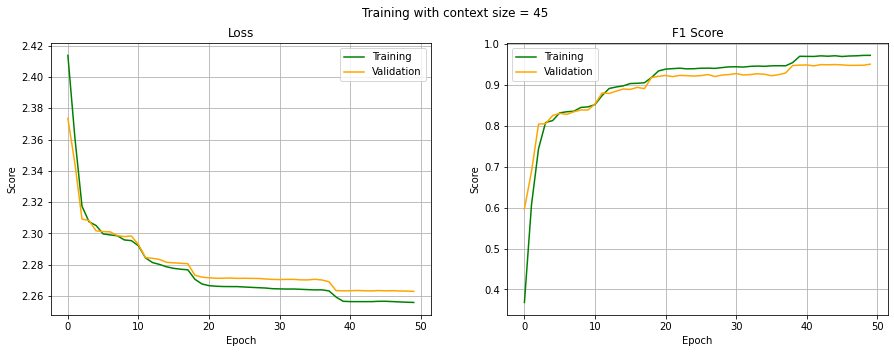

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9733, device='cuda:0'),
 tensor(0.9504, device='cuda:0'),
 tensor(0.9496, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9733, device='cuda:0'),
 tensor(0.9504, device='cuda:0'),
 tensor(0.9496, device='cuda:0'))

## Heatmap

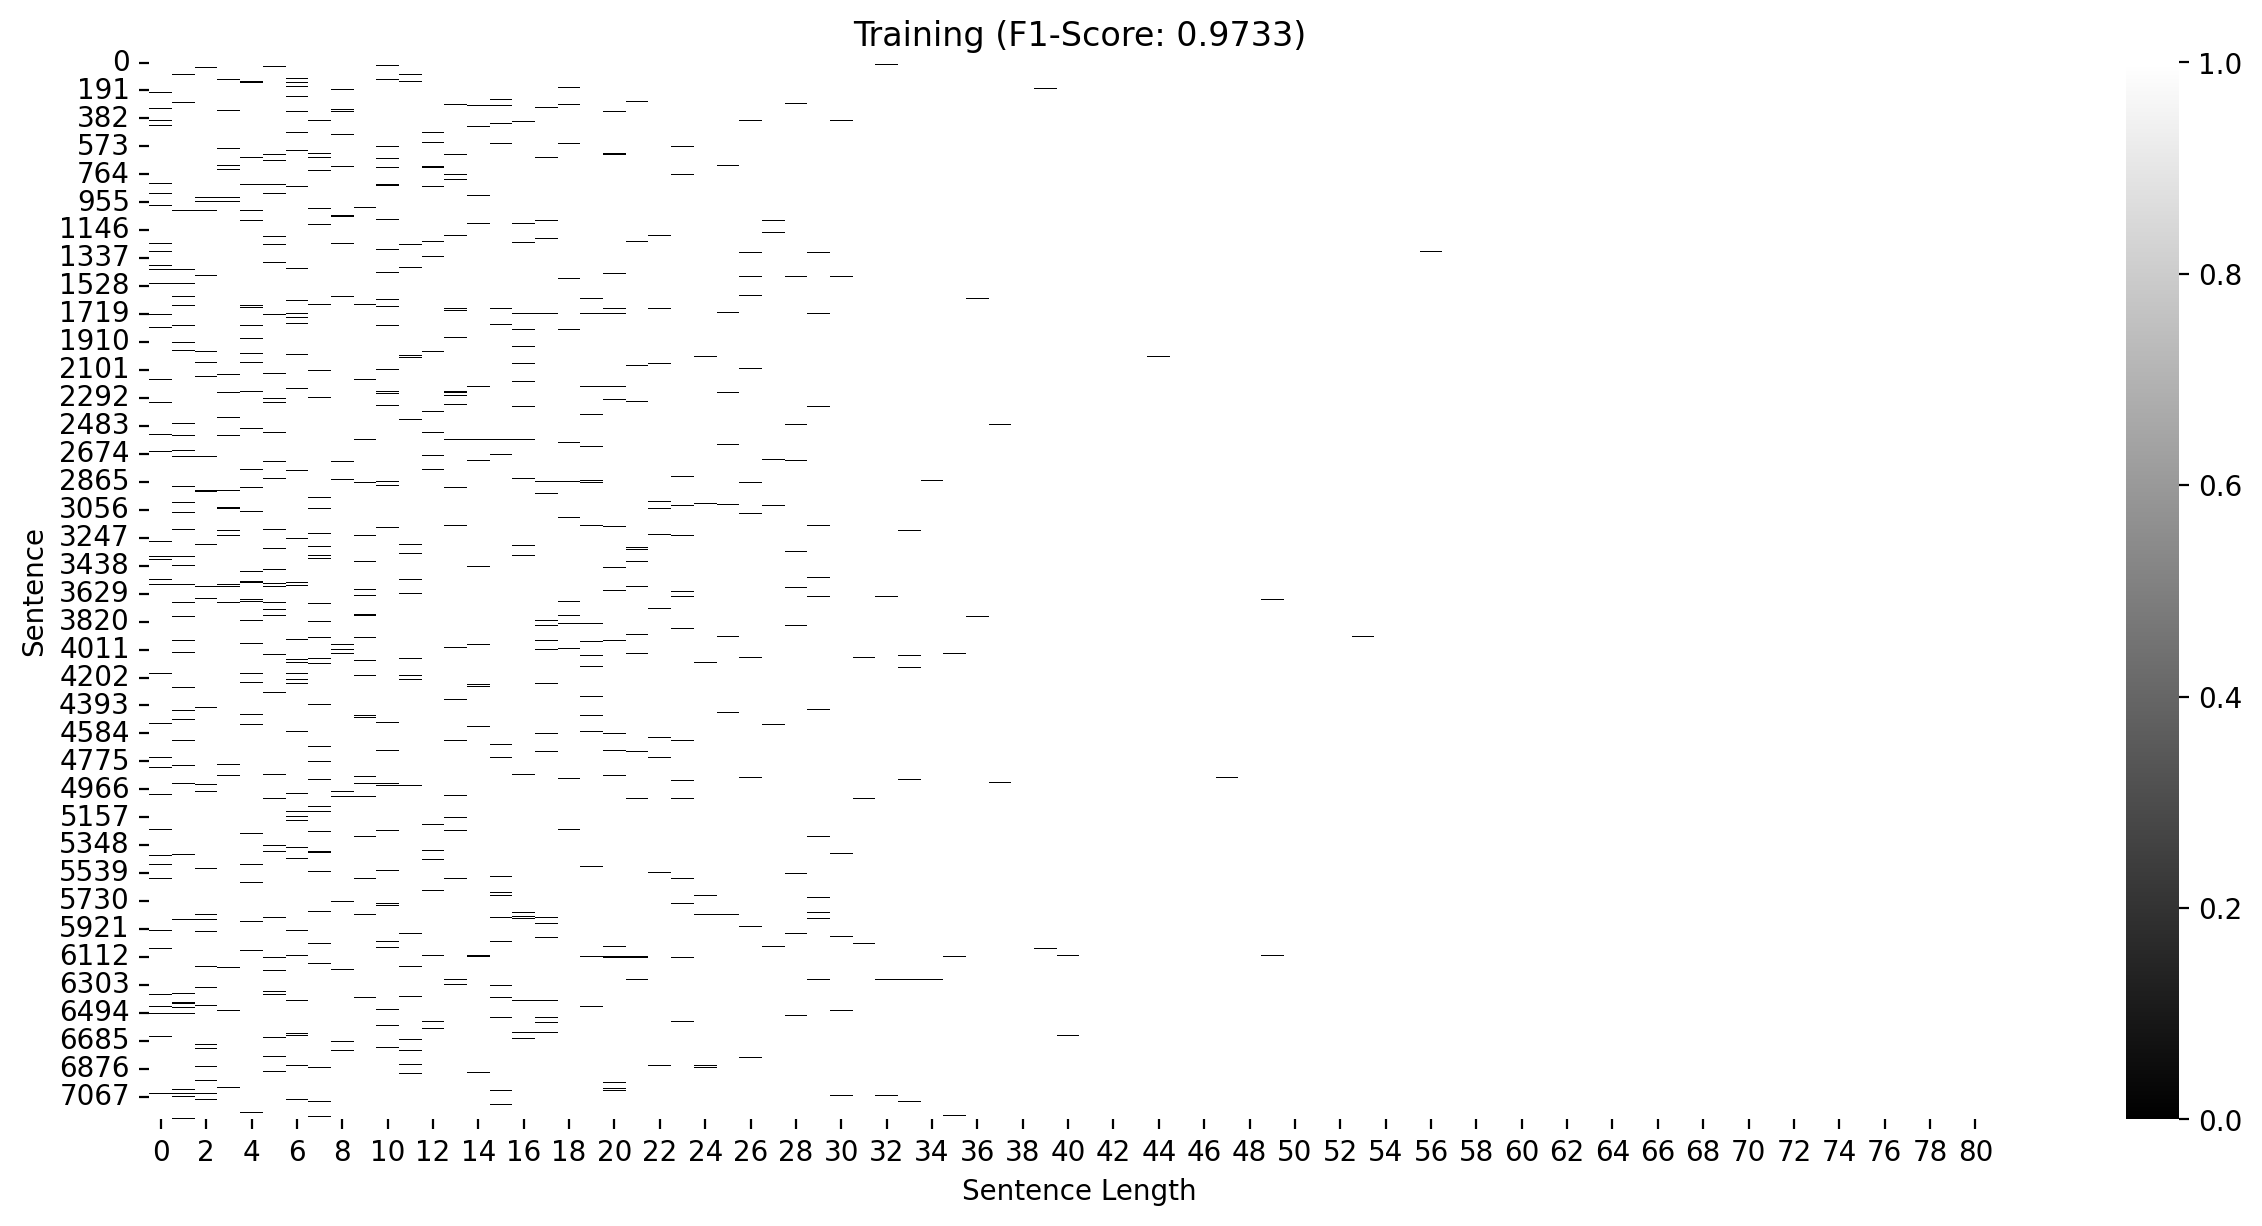

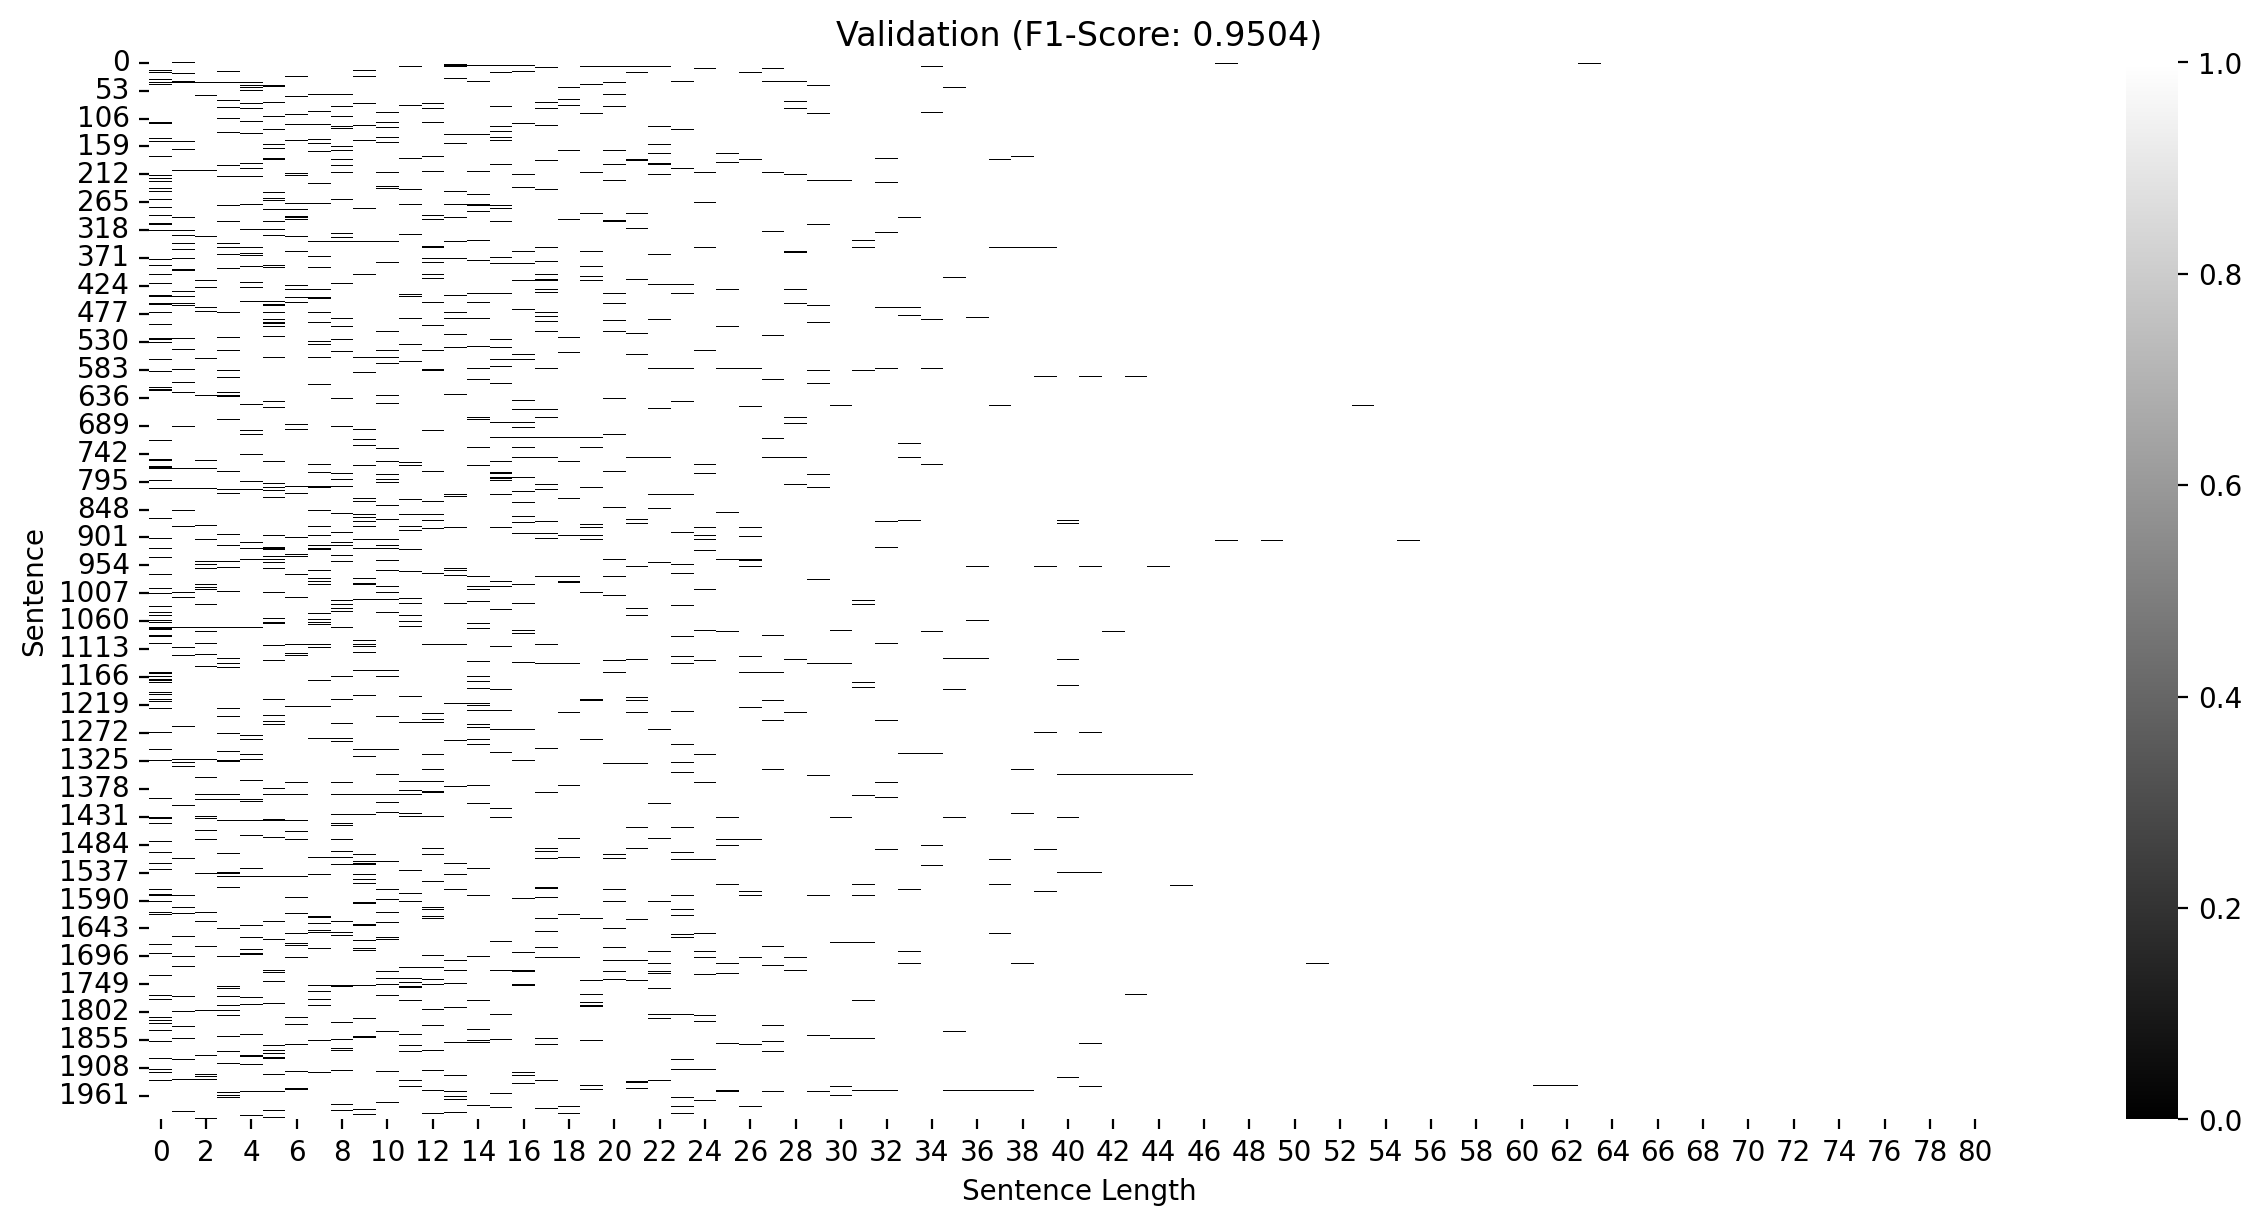

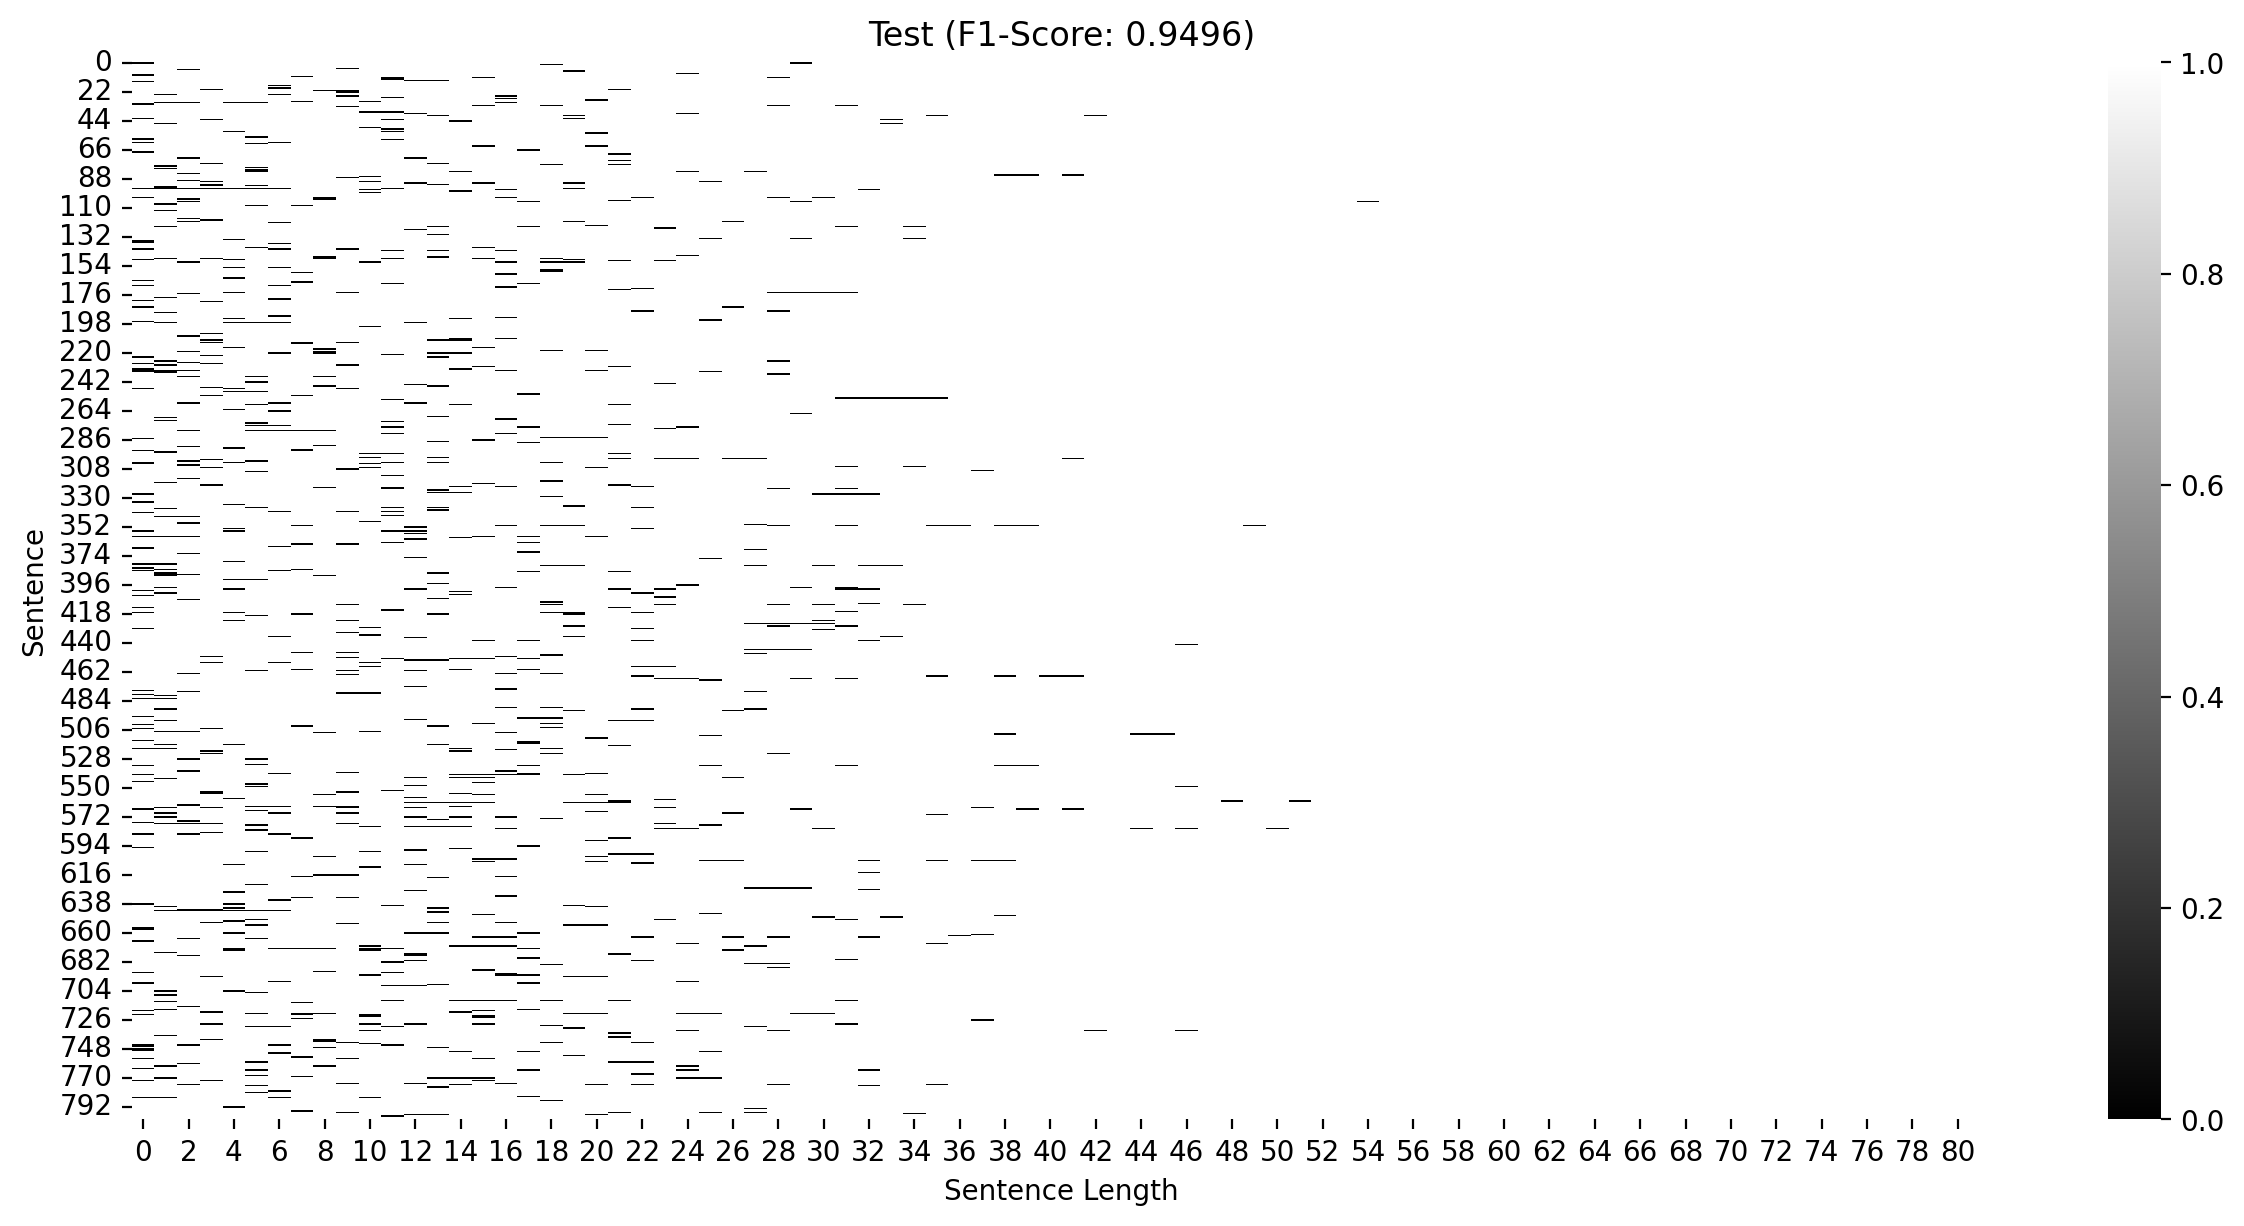

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


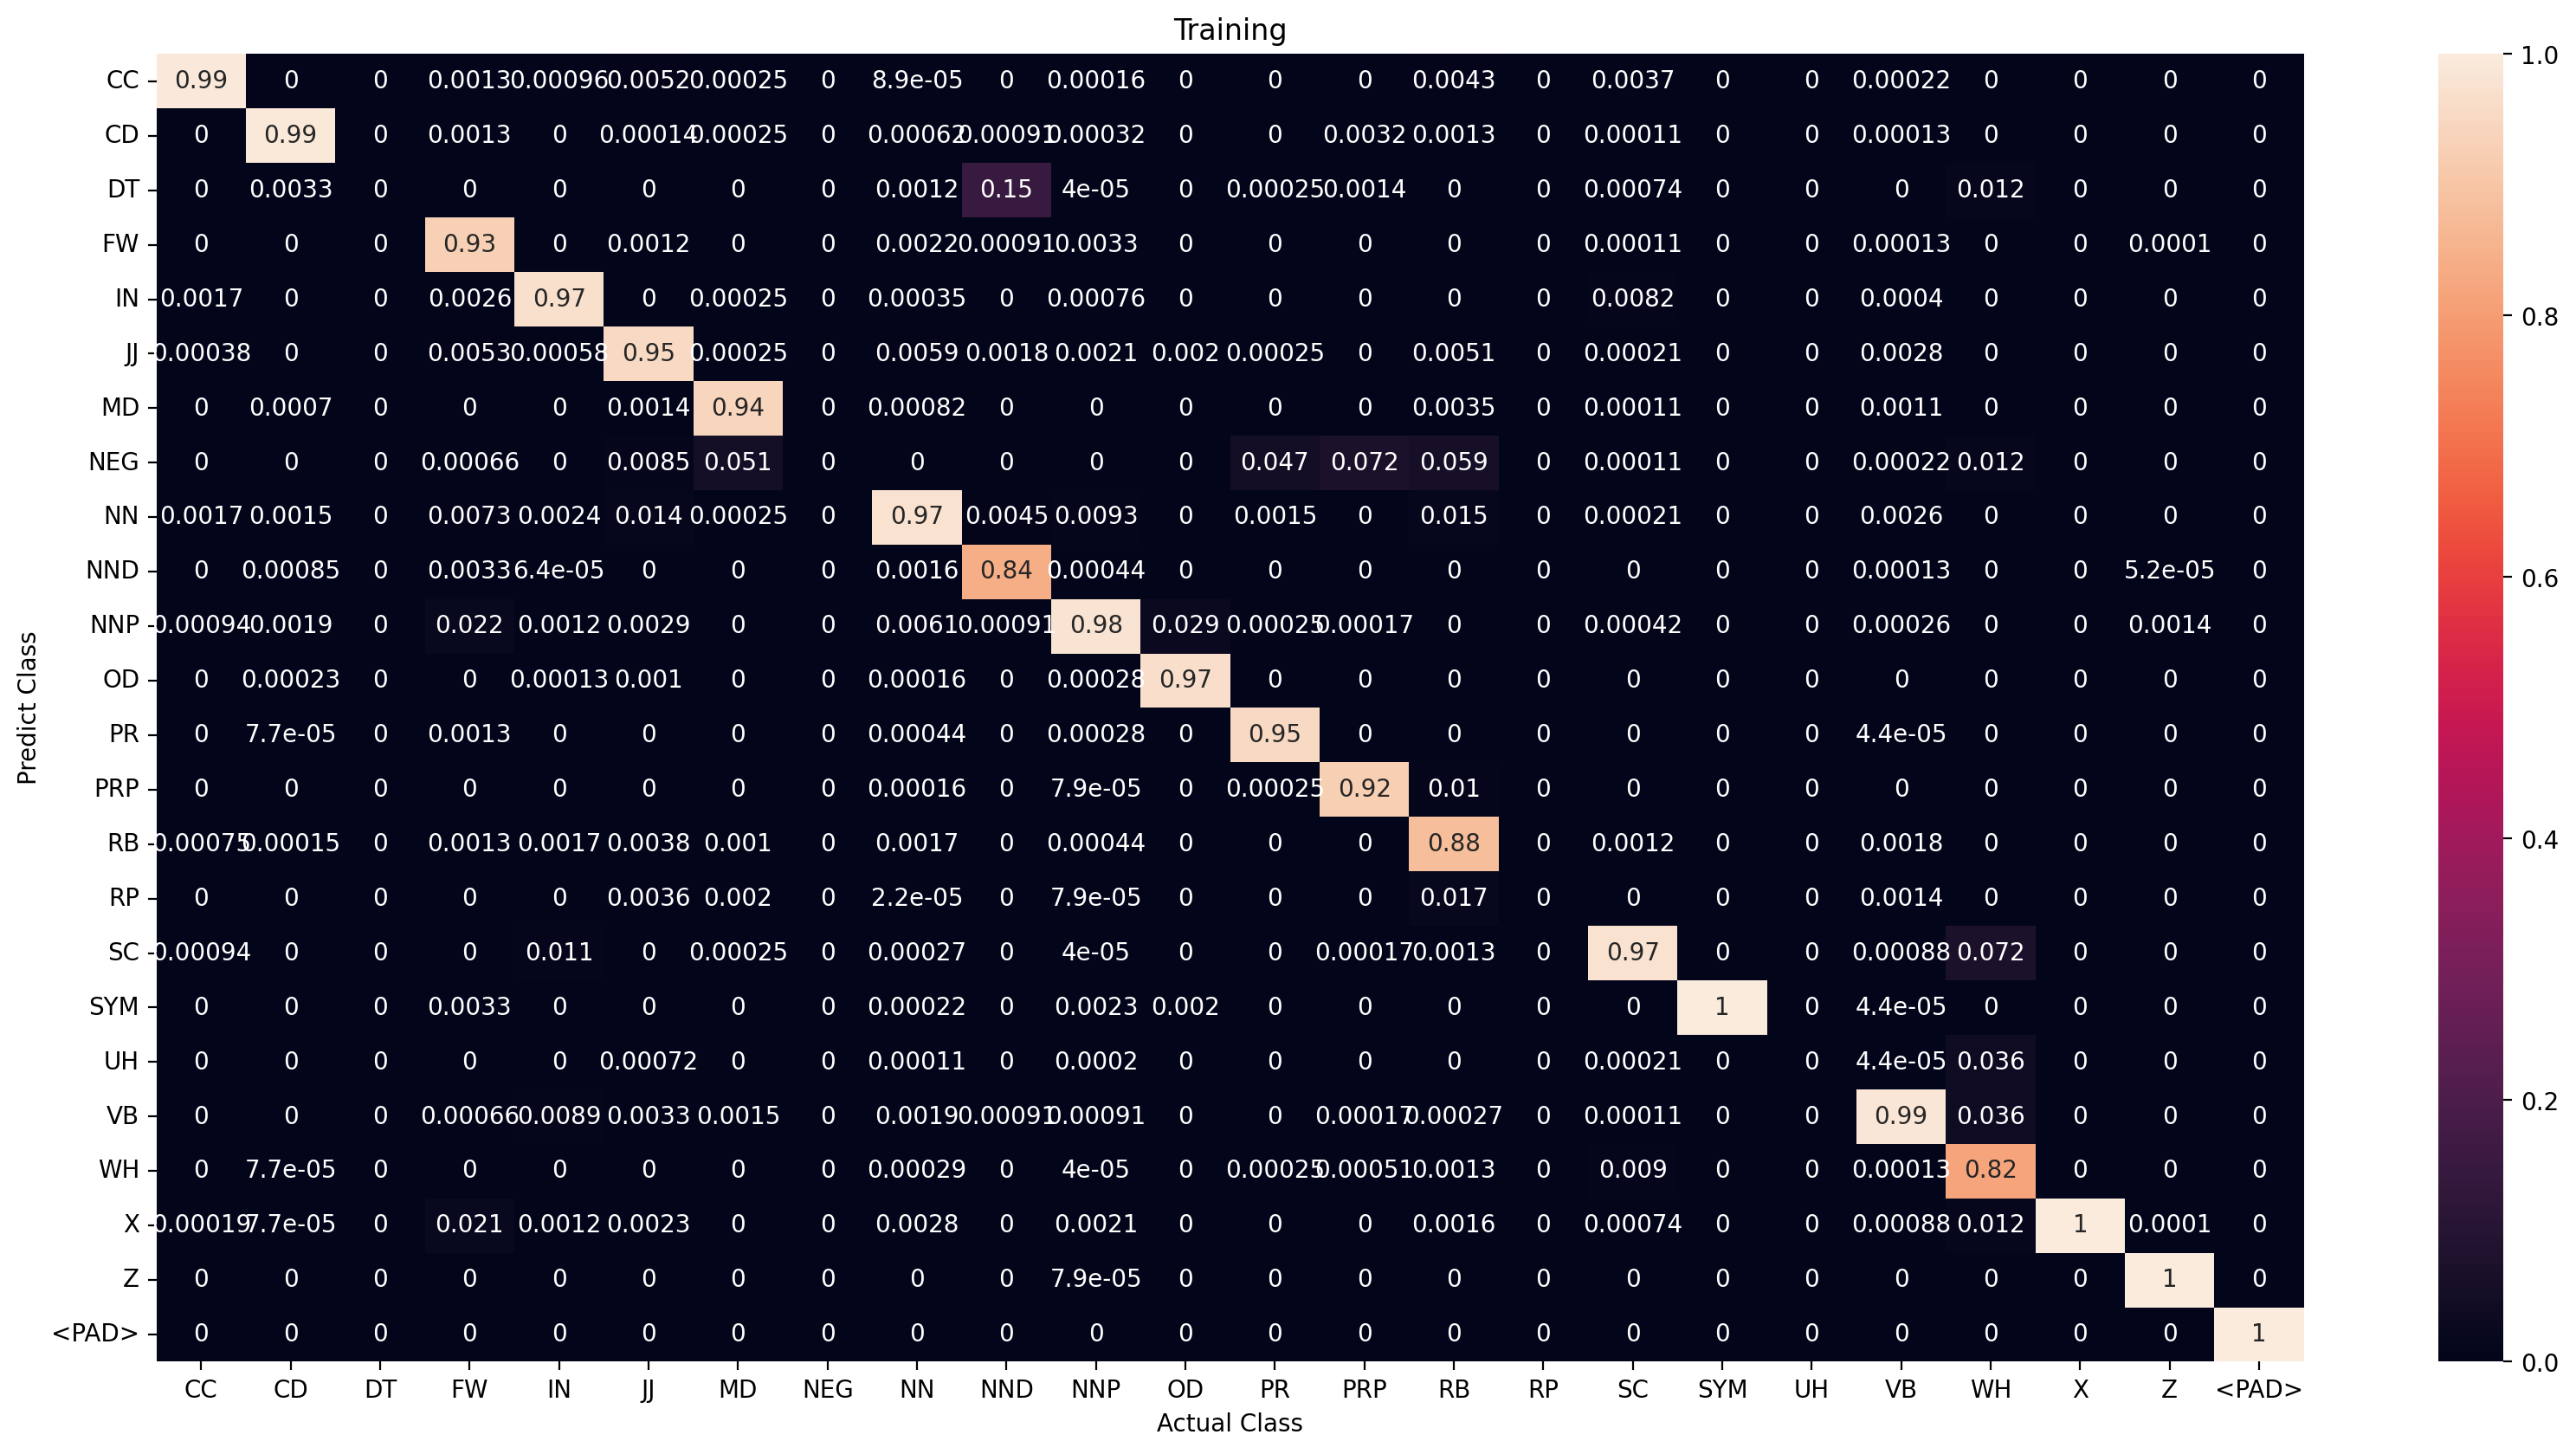

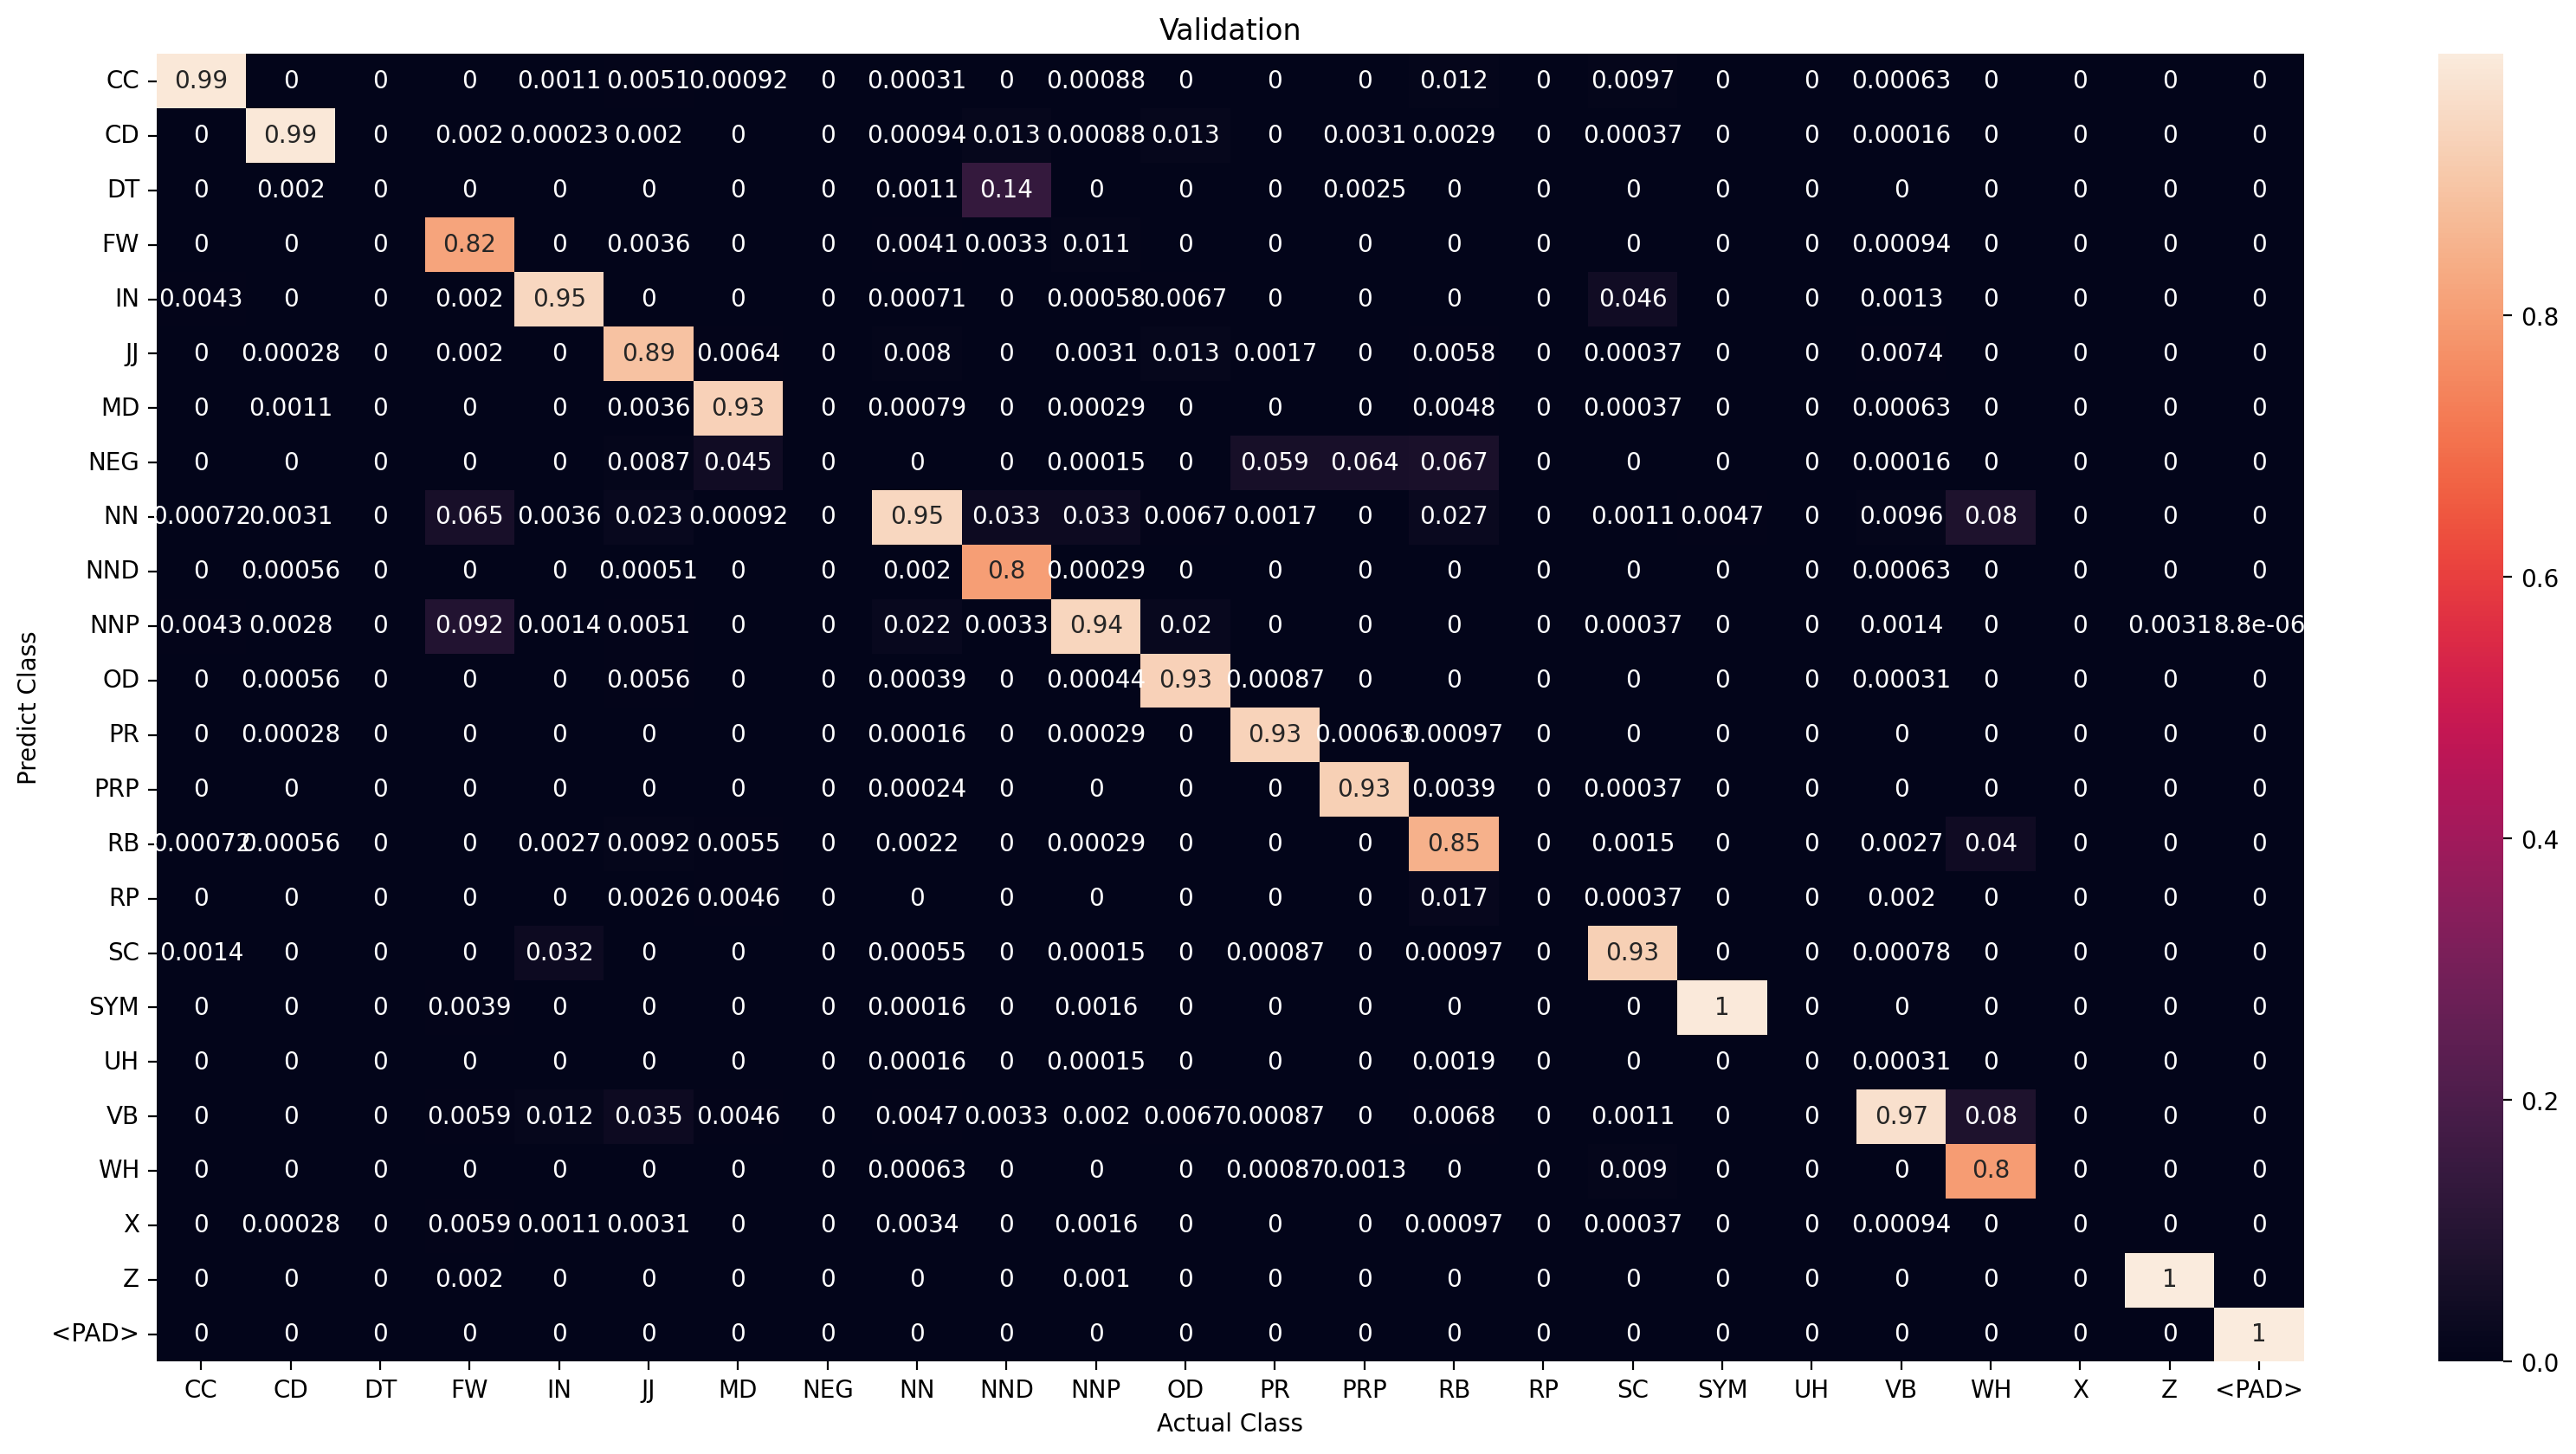

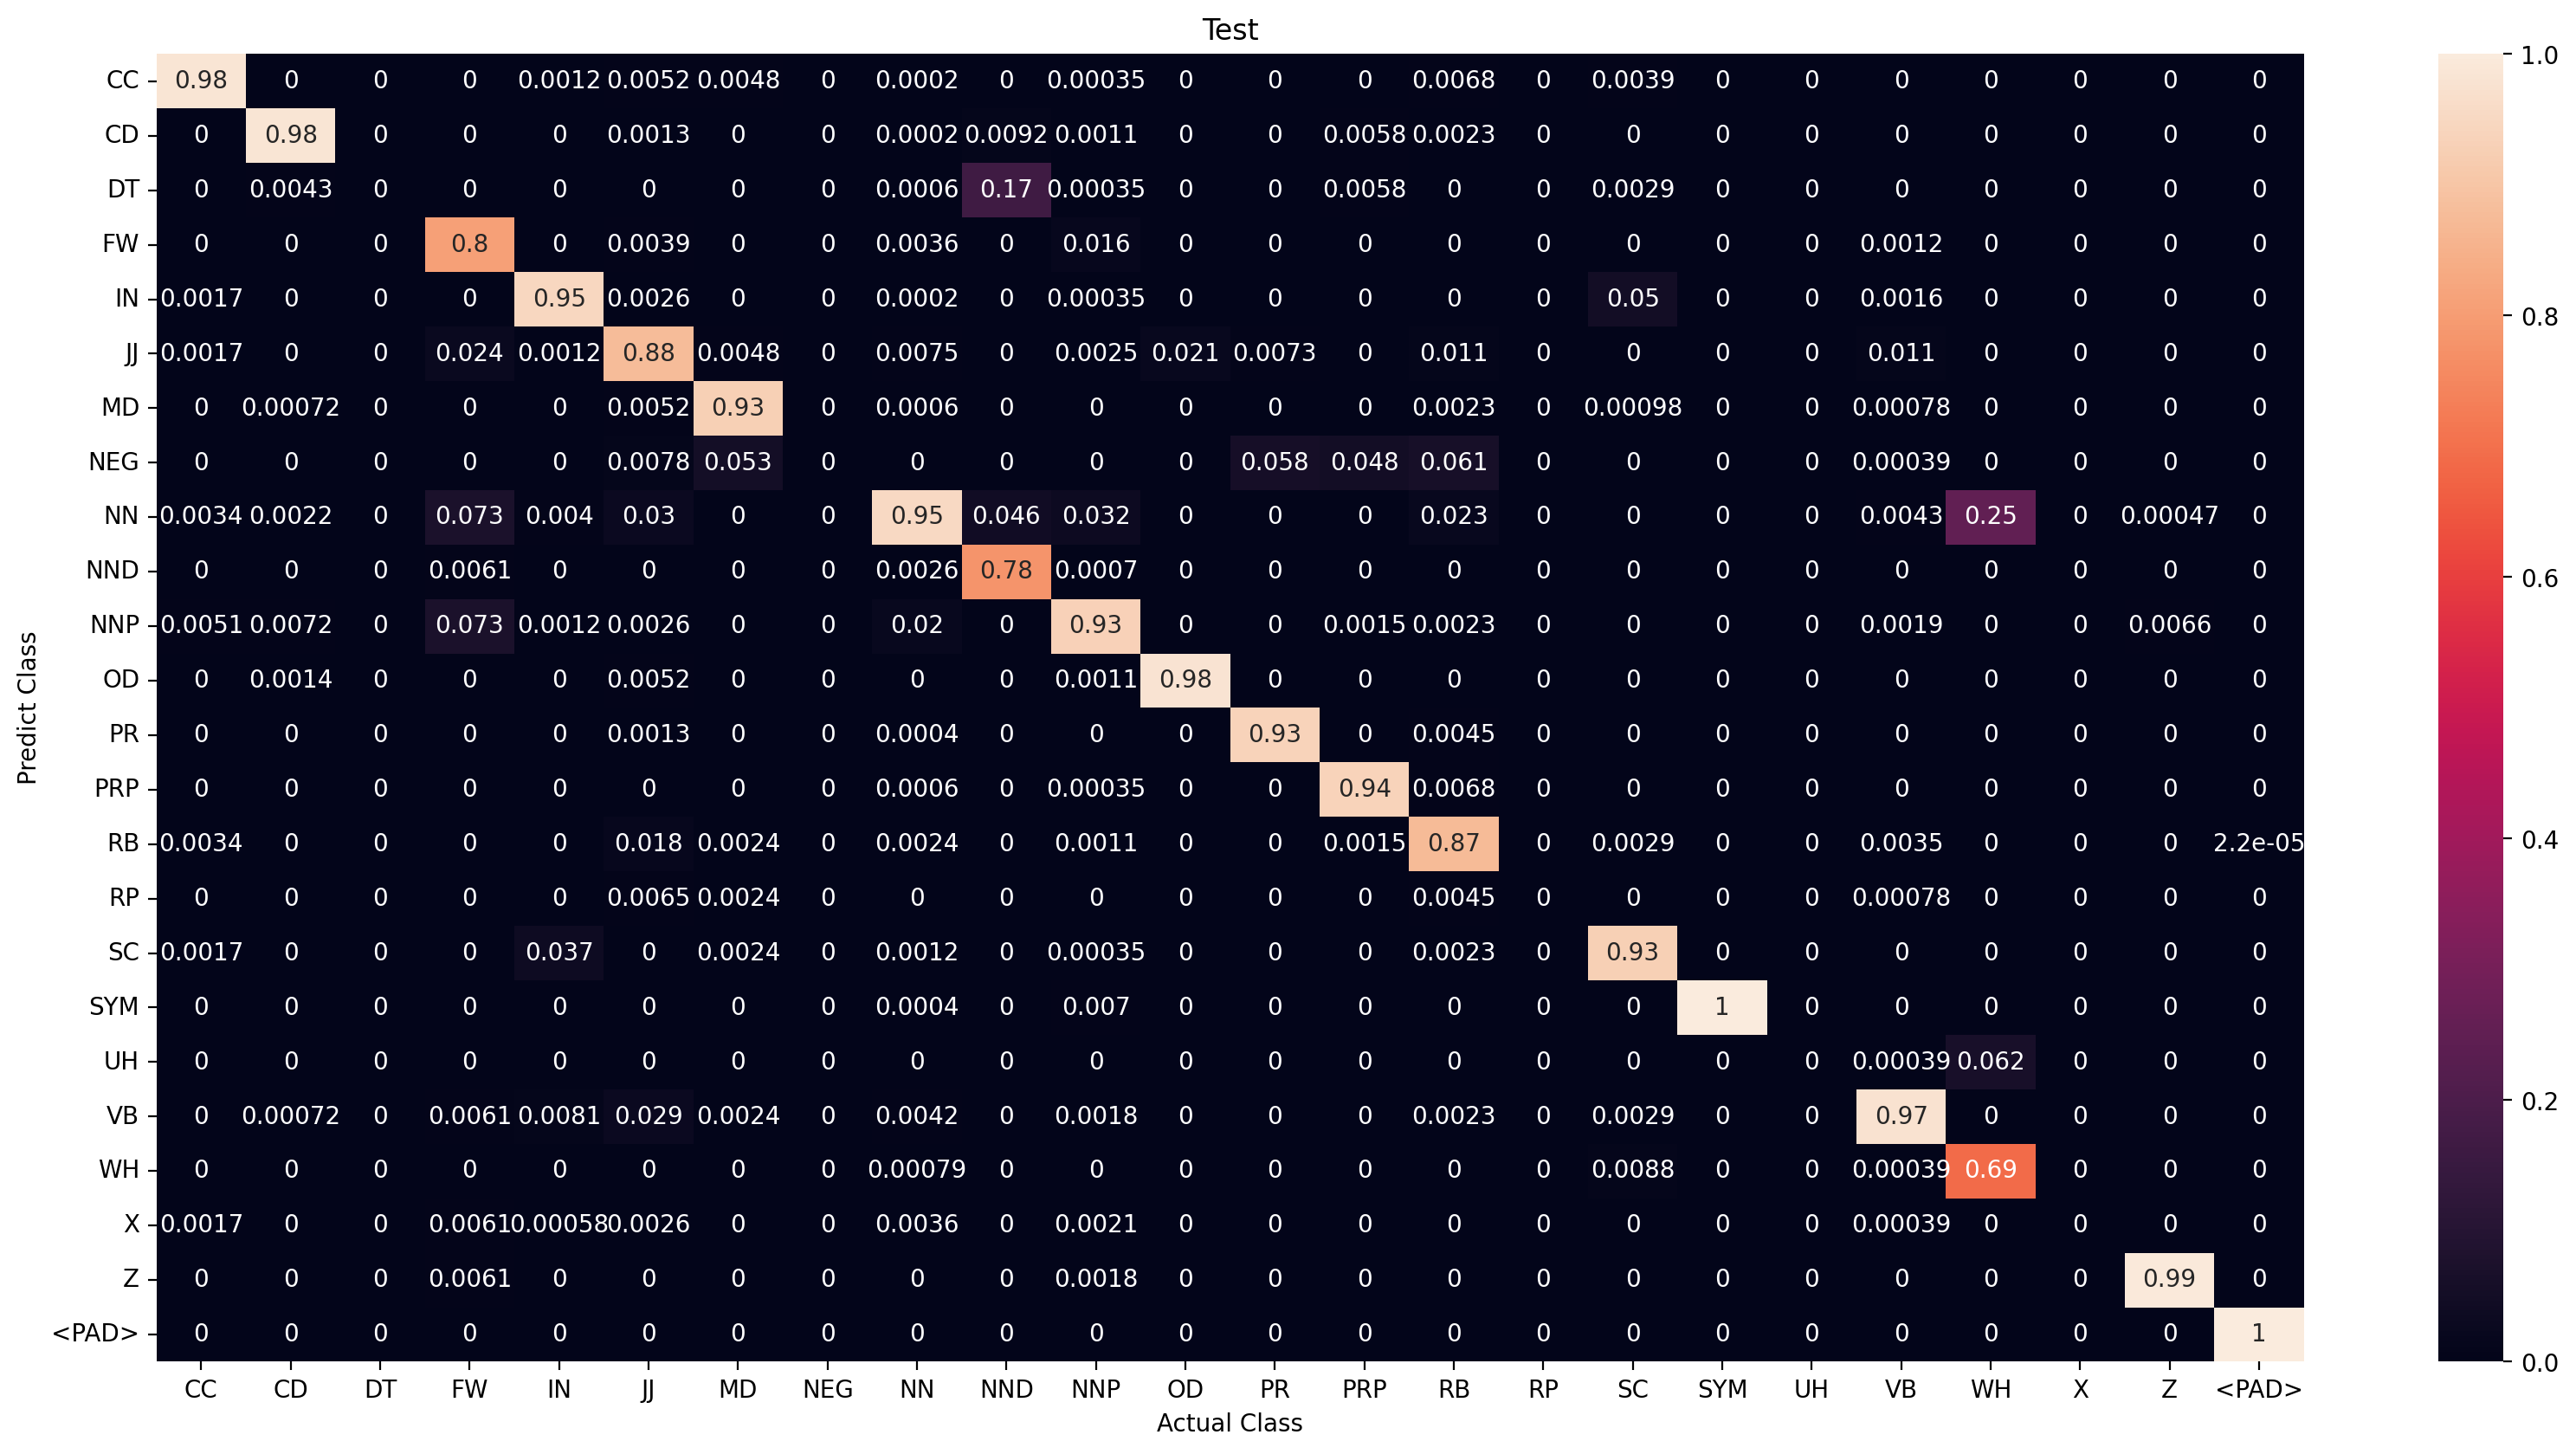

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5279       | CC    : 118      |
| CD    : 12862  | CD    : 12793      | CD    : 69       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1408       | FW    : 197      |
| IN    : 15290  | IN    : 15155      | IN    : 135      |
| JJ    : 7025   | JJ    : 6597       | JJ    : 428      |
| MD    : 3798   | MD    : 3704       | MD    : 94       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43936      | NN    : 536      |
| NND   : 1033   | NND   : 928        | NND   : 105      |
| NNP   : 25007  | NNP   : 24576      | NNP   : 431      |
| OD    : 519    | OD    : 493        | OD    : 26       |
| PR    : 3880   | PR    : 3849       | PR    : 31       |
| PRP   : 5449   | PRP   : 5401       | PRP   : 48       |
| RB    : 3502   | RB    : 3300       | RB    : 202      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11300
Wrong prediction            : 671
Percentage correct oov pred : 94.39478740289033

Validation
Number OOV token            : 3190
Correct prediction          : 2865
Wrong prediction            : 325
Percentage correct oov pred : 89.81191222570533

Test
Number OOV token            : 1401
Correct prediction          : 1268
Wrong prediction            : 133
Percentage correct oov pred : 90.50678087080657



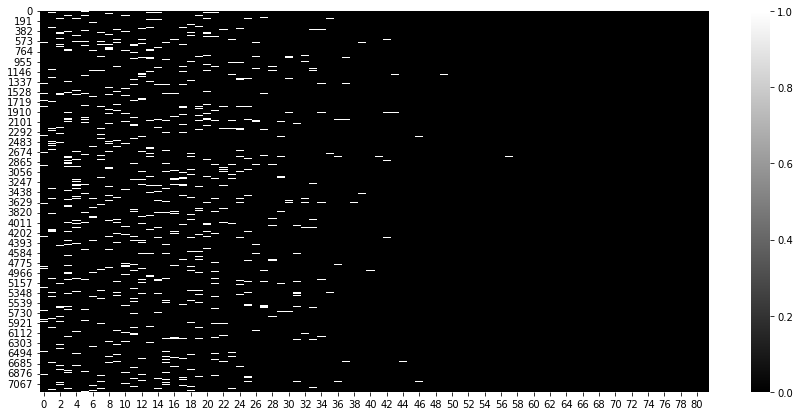

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

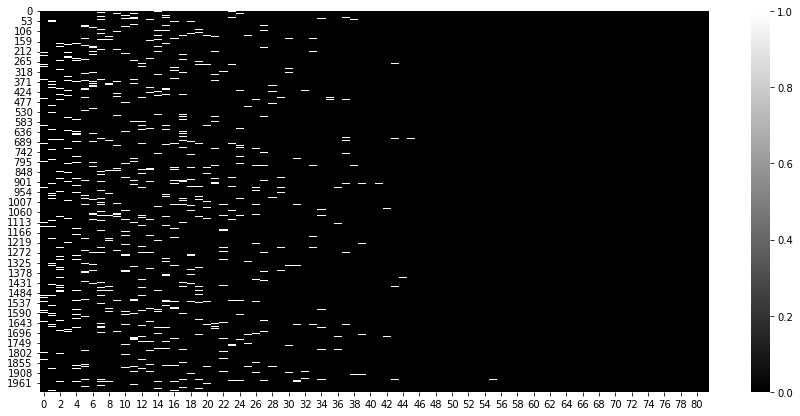

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

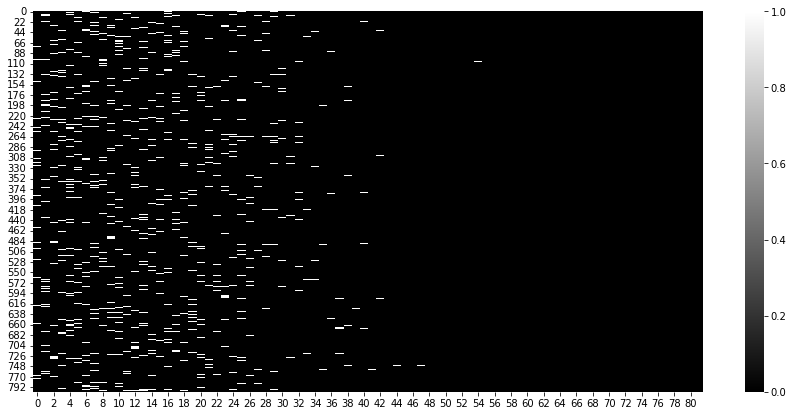

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);